# Исследование о перспективности тарифных планов для телеком-компании

## Краткое описание проекта

Клиентам компании «Мегалайн» предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Необходимо сделать предварительный анализ тарифов на небольшой выборке клиентов. В нашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.
### Описание тарифов
#### Тариф «Смарт»
Ежемесячная плата: 550 рублей. Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика. Стоимость услуг сверх тарифного пакета:
* минута разговора: 3 рубля
* сообщение: 3 рубля
* 1 Гб интернет-трафика: 200 рублей

#### Тариф «Ультра»
Ежемесячная плата: 1950 рублей. Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика. Стоимость услуг сверх тарифного пакета:
* минута разговора: 1 рубль
* сообщение: 1 рубль
* 1 Гб интернет-трафика: 150 рублей

### Описание данных
#### Таблица users (информация о пользователях):
* user_id — уникальный идентификатор пользователя
* first_name — имя пользователя
* last_name — фамилия пользователя
* age — возраст пользователя (годы)
* reg_date — дата подключения тарифа (день, месяц, год)
* churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
* city — город проживания пользователя
* tariff — название тарифного плана

#### Таблица calls (информация о звонках):
* id — уникальный номер звонка
* call_date — дата звонка
* duration — длительность звонка в минутах
* user_id — идентификатор пользователя, сделавшего звонок

#### Таблица messages (информация о сообщениях):
* id — уникальный номер сообщения
* message_date — дата сообщения
* user_id — идентификатор пользователя, отправившего сообщение

#### Таблица internet (информация об интернет-сессиях):
* id — уникальный номер сессии
* mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
* session_date — дата интернет-сессии
* user_id — идентификатор пользователя

#### Таблица tariffs (информация о тарифах):
* tariff_name — название тарифа
* rub_monthly_fee — ежемесячная абонентская плата в рублях
* minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
* messages_included — количество сообщений в месяц, включённых в абонентскую плату
* mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
* rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
* rub_per_message — стоимость отправки сообщения сверх тарифного пакета
* rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

## Обзор данных

Считаем файл, выведем часть строк на экран для знакомства с базой данных:

In [28]:
import pandas as pd                                             # Импортируем библиотеки
import seaborn as sns                                           
import math
import matplotlib.pyplot as plt                                
from scipy import stats as st
import numpy as np

In [29]:
display(pd.read_csv('https://code.s3.yandex.net/datasets/calls.csv',nrows = 5).head())         # Выведем на экран первые 5 строк 
display(pd.read_csv('https://code.s3.yandex.net/datasets/internet.csv',nrows = 5).head())       
display(pd.read_csv('https://code.s3.yandex.net/datasets/messages.csv',nrows = 5).head())        
display(pd.read_csv('https://code.s3.yandex.net/datasets/tariffs.csv',nrows = 5).head())            
display(pd.read_csv('https://code.s3.yandex.net/datasets/users.csv',nrows = 5).head())        

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


Поcледовательно проверив все файлы, приходим к выводу, что все файлы корректно считываются, коррекция разделителя столбцов не требуется.
Также необходимо отметить о существовании общего столбца "user_id", по которому они, вероятно, будут объединены.
Считаем файлы полностью:

In [30]:
df_calls = pd.read_csv('https://code.s3.yandex.net/datasets/calls.csv')                           # Считаем файлы
df_internet = pd.read_csv('https://code.s3.yandex.net/datasets/internet.csv')              
df_messages = pd.read_csv('https://code.s3.yandex.net/datasets/messages.csv')             
df_tariffs = pd.read_csv('https://code.s3.yandex.net/datasets/tariffs.csv')               
df_users = pd.read_csv('https://code.s3.yandex.net/datasets/users.csv')                   
list_table = [df_users, df_calls, df_messages, df_internet, df_tariffs] # Создадим список датафреймов (согл. документации):
for i in list_table:                                                    # Создадим цикл, который пройдет по всему списку
    display(i.head())                                                   # Выведем по 5 строк каждого
    i.info()                                                            # Выведем общую информацию

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


По данным информации, отображенной на экране в предыдущих двух ячейках, можно сделать план предобработки данных:

### Обзор проблем с датафреймами (план предобработки): 
<a class="anchor" id="plan"></a>
* df_users
    * порядок столбцов отличается от документации;
    * столбцу 'reg_date' изменить тип на временной;
    * столбцу 'tariff' изменить тип на категориальный
* df_calls
    * столбцу 'call_date' изменить тип на временной.
* df_messages
    * столбцу 'message_date' изменить тип на временной.
* df_internet
    * столбец 'Unnamed: 0' не несет информативной нагрузки и должен быть удален;
    * столбцу 'session_date' изменить тип на временной;
* df_tariffs
    * порядок столбцов отличается от документации.

## Предобработка

### Заполнение пропусков
Пропуски есть только в датафрейме "df_users" в столбце "churn_date" (дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных), поэтому заменять их не следует. Поэтому в целом заполнение пропусков не требуется.

### Удаление дубликатов

Проверим наличие явных дубликатов в датафреймах, выведем их на экран. 

Учитывая характер данных, искать неявные дубликаты попросту негде. Единственный столбец, неявные дубликаты в котором могут  повлиять на результат исследования выведем на экран:

In [31]:
list_table = [df_users, df_calls, df_messages, df_internet, df_tariffs] # Создадим список датафреймов (согл. документации):
for i in list_table:                                                    # Создадим цикл, который пройдет по всему списку
    display(i.duplicated().sum())                                       # Выведем по 5 строк каждого
df_users['tariff'].unique()                                             # Вывод уникальных значений данного столбца

0

0

0

0

0

array(['ultra', 'smart'], dtype=object)

Промежуточный вывод: дубликатов нет, их удаление и замена не требуется

### Изменение очередности столбцов
Как было указано выше, в датафрейме df_users и df_tariffs порядок столбцов отличается от документации, исправим это:

In [32]:
                                        # Сначала создадим желаемый список (согласно документации):
list_columns_int = ['user_id','first_name','last_name', 'age','reg_date', 'churn_date','city', 'tariff']
display(df_users.head(0))               # Столбцы до 
df_users = df_users[list_columns_int]
display(df_users.head(0))               # Столбцы после

                                        # Сначала создадим желаемый список (согласно документации):
list_columns_int_2 = ['tariff_name','rub_monthly_fee','minutes_included',
    'messages_included','mb_per_month_included','rub_per_minute','rub_per_message','rub_per_gb']
display(df_tariffs.head(0))             # Столбцы до 
df_tariffs = df_tariffs[list_columns_int_2]
display(df_tariffs.head(0))             # Столбцы после

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff


,user_id,first_name,last_name,age,reg_date,churn_date,city,tariff


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name


,tariff_name,rub_monthly_fee,minutes_included,messages_included,mb_per_month_included,rub_per_minute,rub_per_message,rub_per_gb


Промежуточный вывод: порядок столбцов откорректирован и соответствует документации.

### Изменение типов данных
Изменим тип данных в соответствие с ранее озвученным [планом](#plan) 

In [33]:
df_users['tariff'] = df_users['tariff'].astype('category')   # Заменяем тип на category
display(df_users.dtypes)                                     # Проверяем

                                                             # Преобразуем текст в дату:
df_users['reg_date'] = pd.to_datetime(df_users['reg_date'],
    format='%Y-%m-%d')                                       # Было 2018-05-25
display(df_users['reg_date'].head(2))                        # Проверим

df_users['churn_date'] = pd.to_datetime(df_users['churn_date'],
    format='%Y-%m-%d')                                       # Было 2018-05-25

df_calls['call_date'] = pd.to_datetime(df_calls['call_date'],
    format='%Y-%m-%d')                                       # Было 2018-06-27
display(df_calls['call_date'].head(2))                       # Проверим
 
df_messages['message_date'] = pd.to_datetime(df_messages['message_date'],
    format='%Y-%m-%d')                                       # Было 2018-07-25
display(df_messages['message_date'].head(2))                 # Проверим

df_internet['session_date'] = pd.to_datetime(df_internet['session_date'],
    format='%Y-%m-%d')                                       # Было 2018-11-25 
display(df_internet['session_date'].head(2))                 # Проверим

df_internet = df_internet.drop('Unnamed: 0',axis=1)          # Удалим столбец 
display(df_internet.head(2))                                 # Проверяем


user_id          int64
first_name      object
last_name       object
age              int64
reg_date        object
churn_date      object
city            object
tariff        category
dtype: object

0   2018-05-25
1   2018-11-01
Name: reg_date, dtype: datetime64[ns]

0   2018-07-25
1   2018-08-17
Name: call_date, dtype: datetime64[ns]

0   2018-06-27
1   2018-10-08
Name: message_date, dtype: datetime64[ns]

0   2018-11-25
1   2018-09-07
Name: session_date, dtype: datetime64[ns]

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000


Промежуточный вывод: тип данных изменен в соответствие с планом.

### Проверка данных на аномалии и исправления

Для проверки данных на аномалии вызовем статистическую информацию методом describe() о всех датафреймах (с числовыми значениями).

In [34]:
display(df_users.describe())                 # Выведем статистическую информацию
display(df_calls.describe())                 # Выведем статистическую информацию
display(df_messages.describe())              # Выведем статистическую информацию
display(df_internet.describe())              # Выведем статистическую информацию

,user_id,age
count,500.000000,500.00000
mean,1249.500000,46.58800
std,144.481833,16.66763
min,1000.000000,18.00000
25%,1124.750000,32.00000
50%,1249.500000,46.00000
75%,1374.250000,62.00000
max,1499.000000,75.00000


,duration,user_id
count,202607.000000,202607.000000
mean,6.755887,1253.940619
std,5.843365,144.722751
min,0.000000,1000.000000
25%,1.300000,1126.000000
50%,6.000000,1260.000000
75%,10.700000,1379.000000
max,38.000000,1499.000000


,user_id
count,123036.000000
mean,1256.989410
std,143.523967
min,1000.000000
25%,1134.000000
50%,1271.000000
75%,1381.000000
max,1499.000000


,mb_used,user_id
count,149396.000000,149396.000000
mean,370.192426,1252.099842
std,278.300951,144.050823
min,0.000000,1000.000000
25%,138.187500,1130.000000
50%,348.015000,1251.000000
75%,559.552500,1380.000000
max,1724.830000,1499.000000


Промежуточный вывод: по данным статистической информации каких-либо аномалий не прослеживается.

### Категоризация данных

Имеющиеся данные в дополнительной категоризации не нуждаются, и заданием не предусмотрены.

Но изменим индексы в последней таблице на наименование тарифа для более легкого вызова значений из этой таблицы

In [35]:
df_tariffs.index = df_tariffs['tariff_name']
df_tariffs.head()

,tariff_name,rub_monthly_fee,minutes_included,messages_included,mb_per_month_included,rub_per_minute,rub_per_message,rub_per_gb
tariff_name,,,,,,,,
smart,smart,550,500,50,15360,3,3,200
ultra,ultra,1950,3000,1000,30720,1,1,150


### Дополнение данных

Для начала работы необходимо убедиться во временном интервале (согласно документации данные представлены за все месяцы 2018 года):

In [36]:
list_columns_date = [df_users['reg_date'],df_calls['call_date'],
                     df_messages['message_date'], df_internet['session_date']]
for i in list_columns_date:              # Создадим цикл, который пройдет по всему списку
    print(i.min(),' - ',i.max()) 

2018-01-01 00:00:00  -  2018-12-31 00:00:00
2018-01-01 00:00:00  -  2018-12-31 00:00:00
2018-01-02 00:00:00  -  2018-12-31 00:00:00
2018-01-01 00:00:00  -  2018-12-31 00:00:00


Следовательно, временной интервал действительно ограничивается одним календарным годом, или 12 месяцами, и все данные можно дифференцировать среди 12 месяцев (например, при помощи сводной таблицы).

#### Создание сводных таблиц
Создадим сводные таблицы по данным датафреймов df_calls, df_messages, df_internet и посчитаем для каждого пользователя продолжительность телефонных разговоров, количество СМС, потребленный объем трафика интернета в соответствующих таблицах:

In [37]:
# Округление продолжительности разговора в минутах  (добавлено):
#display(df_calls.head())                                      # Просмотр до округления
df_calls['duration'] = np.ceil(df_calls['duration'])           # Непосредственно округление
#display(df_calls.head())                                      # Просмотр после округления

# Продолжительность разговора:
pivot_calls = df_calls.pivot_table(index=['user_id',df_calls['call_date'].dt.month],    # Создаём сводную таблицу (стало)
    values='duration',aggfunc=['sum','count'])
display(pivot_calls.head())                                   # Проверяем

# Количество СМС:
pivot_messages = df_messages.pivot_table(index=['user_id',df_messages['message_date'].dt.month],   #стало
    values='message_date',aggfunc='count')
pivot_messages = pivot_messages.rename(columns={'message_date':'count_sms'})         # переименование столбца (добавлено)
display(pivot_messages.head())

# Интернет-трафик:
pivot_internet = df_internet.pivot_table(index=['user_id',df_internet['session_date'].dt.month],   #стало
    values='mb_used',aggfunc='sum')
#display(pivot_internet.head())                                               # Просмотр что получилось до округления

# Округление интернет-трафика        (добавлено):
pivot_internet['gb_used'] = np.ceil(pivot_internet['mb_used']/1024)           # округление             (добавлено)
display(pivot_internet.head())                                                # Проверяем

sum    count
                  duration duration
user_id call_date                  
1000    5            159.0       22
        6            172.0       43
        7            340.0       47
        8            408.0       52
        9            466.0       58

count_sms
user_id message_date           
1000    5                    22
        6                    60
        7                    75
        8                    81
        9                    57

mb_used  gb_used
user_id session_date                   
1000    5              2253.49      3.0
        6             23233.77     23.0
        7             14003.64     14.0
        8             14055.93     14.0
        9             14568.91     15.0

Промежуточный вывод: сводные таблицы с помесячной статистикой телефонных разговоров (в минутах), СМС-ок (в штуках), интернет-трафика (в мегабайтах) добавлены.

#### Добавление помесячной выручки
Итак, для дальнейшего анализа нужно будет в соответствии с заданием в одной из таблиц отобразить помесячную выручку с каждого из 500 пользователей.

Для начала объединим таблицы по уникальному идентификатору пользователя...

In [38]:
pivot_calls = pivot_calls.reset_index()
pivot_calls.columns = ['user_id', 'month','duration','count']

pivot_messages = pivot_messages.reset_index()
pivot_messages.columns = ['user_id', 'month','count_sms']

pivot_internet = pivot_internet.reset_index()
pivot_internet.columns = ['user_id', 'month','mb_used','gb_used']

display(pivot_calls.head())   
display(pivot_messages.head())
display(pivot_internet.head())

df_users_all = pivot_calls.merge(pivot_messages, on=['user_id','month'],how='outer')
df_users_all = df_users_all.merge(pivot_internet, on=['user_id','month'],how='outer')

df_users_all = df_users_all.fillna(0) # Заполнение пропусков нулями

display(df_users_all.head(10))

,user_id,month,duration,count
0,1000,5,159.0,22
1,1000,6,172.0,43
2,1000,7,340.0,47
3,1000,8,408.0,52
4,1000,9,466.0,58


,user_id,month,count_sms
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


,user_id,month,mb_used,gb_used
0,1000,5,2253.49,3.0
1,1000,6,23233.77,23.0
2,1000,7,14003.64,14.0
3,1000,8,14055.93,14.0
4,1000,9,14568.91,15.0


,user_id,month,duration,count,count_sms,mb_used,gb_used
0,1000,5,159.0,22.0,22.0,2253.49,3.0
1,1000,6,172.0,43.0,60.0,23233.77,23.0
2,1000,7,340.0,47.0,75.0,14003.64,14.0
3,1000,8,408.0,52.0,81.0,14055.93,14.0
4,1000,9,466.0,58.0,57.0,14568.91,15.0
5,1000,10,350.0,57.0,73.0,14702.49,15.0
6,1000,11,338.0,43.0,58.0,14756.47,15.0
7,1000,12,333.0,46.0,70.0,9817.61,10.0
8,1001,11,430.0,59.0,0.0,18429.34,18.0
9,1001,12,414.0,63.0,0.0,14036.66,14.0


Проведем проверку, корректно ли было проведено объединение:

In [39]:
print('Изменение суммы после объединения',pivot_calls.duration.sum()-df_users_all.duration.sum())
print('Изменение суммы после объединения',pivot_messages.count_sms.sum()-df_users_all.count_sms.sum())
print('Изменение суммы после объединения',pivot_internet['gb_used'].sum()-df_users_all.gb_used.sum())

Изменение суммы после объединения 0.0
Изменение суммы после объединения 0.0
Изменение суммы после объединения 0.0


После добавления всех данных в таблицу нам потребуется расчет выручки, а для расчета выручки нужено возвратить тариф каждого пользователя. Поскольку успех данного действа сомнителен внутри функции, придется добавить тариф к имеющемуся объединенному датафрейму.

Для этого заменим индексы в датаврейме на user_id:

In [40]:
df_users.set_index('user_id',inplace=True) # заменяем индексы на id чтобы легко можно было к нему обратиться
display(df_users.head(10))

,first_name,last_name,age,reg_date,churn_date,city,tariff
user_id,,,,,,,
1000,Рафаил,Верещагин,52,2018-05-25,NaT,Краснодар,ultra
1001,Иван,Ежов,41,2018-11-01,NaT,Москва,smart
1002,Евгений,Абрамович,59,2018-06-17,NaT,Стерлитамак,smart
1003,Белла,Белякова,23,2018-08-17,NaT,Москва,ultra
1004,Татьяна,Авдеенко,68,2018-05-14,NaT,Новокузнецк,ultra
1005,Афанасий,Горлов,67,2018-01-25,NaT,Набережные Челны,smart
1006,Леонид,Ермолаев,21,2018-02-26,NaT,Ульяновск,smart
1007,Юна,Березина,65,2018-04-19,NaT,Москва,smart
1008,Рустэм,Пономарёв,63,2018-12-19,NaT,Челябинск,smart


Необходимо объединить объединенную таблицу с столбцом 'tariff' датафрейма df_users:

In [41]:
df_users_all = df_users_all.merge(df_users['tariff'], on='user_id',how='outer')
df_users_all.head(10)

,user_id,month,duration,count,count_sms,mb_used,gb_used,tariff
0,1000,5.0,159.0,22.0,22.0,2253.49,3.0,ultra
1,1000,6.0,172.0,43.0,60.0,23233.77,23.0,ultra
2,1000,7.0,340.0,47.0,75.0,14003.64,14.0,ultra
3,1000,8.0,408.0,52.0,81.0,14055.93,14.0,ultra
4,1000,9.0,466.0,58.0,57.0,14568.91,15.0,ultra
5,1000,10.0,350.0,57.0,73.0,14702.49,15.0,ultra
6,1000,11.0,338.0,43.0,58.0,14756.47,15.0,ultra
7,1000,12.0,333.0,46.0,70.0,9817.61,10.0,ultra
8,1001,11.0,430.0,59.0,0.0,18429.34,18.0,smart
9,1001,12.0,414.0,63.0,0.0,14036.66,14.0,smart


и только теперь можно поработать с функцией:

In [42]:
def calc (stroka):
    user_id = stroka['user_id']
    tariff = stroka['tariff']
    rub_monthly_fee = df_tariffs.loc[tariff,'rub_monthly_fee'] # Абон.плату за месяц
    minutes_included = df_tariffs.loc[tariff,'minutes_included'] # план по минутам
    messages_included = df_tariffs.loc[tariff,'messages_included'] # план по СМС
    mb_per_month_included = df_tariffs.loc[tariff,'mb_per_month_included'] # план по Мбайтам
    rub_per_minute = df_tariffs.loc[tariff,'rub_per_minute'] # руб/мин сверх плана
    rub_per_message = df_tariffs.loc[tariff,'rub_per_message'] # руб/СМС сверх плана
    rub_per_gb = df_tariffs.loc[tariff,'rub_per_gb'] # руб/Гб сверх лимита
    total = rub_monthly_fee
    if stroka['duration'] > minutes_included: # если минут больше плана, то
        total += (stroka['duration']-minutes_included)*rub_per_minute
    if stroka['count_sms'] > messages_included:
            total += (stroka['count_sms']-messages_included)*rub_per_message
    if stroka['gb_used'] > mb_per_month_included/1024: # если Мб больше плана, то
            total += (stroka['gb_used']-mb_per_month_included/1024)*rub_per_gb    
    return total
df_users_all['total'] = df_users_all.apply(calc,axis=1)
display(df_users_all.head(20))

,user_id,month,duration,count,count_sms,mb_used,gb_used,tariff,total
0,1000,5.0,159.0,22.0,22.0,2253.49,3.0,ultra,1950.0
1,1000,6.0,172.0,43.0,60.0,23233.77,23.0,ultra,1950.0
2,1000,7.0,340.0,47.0,75.0,14003.64,14.0,ultra,1950.0
3,1000,8.0,408.0,52.0,81.0,14055.93,14.0,ultra,1950.0
4,1000,9.0,466.0,58.0,57.0,14568.91,15.0,ultra,1950.0
5,1000,10.0,350.0,57.0,73.0,14702.49,15.0,ultra,1950.0
6,1000,11.0,338.0,43.0,58.0,14756.47,15.0,ultra,1950.0
7,1000,12.0,333.0,46.0,70.0,9817.61,10.0,ultra,1950.0
8,1001,11.0,430.0,59.0,0.0,18429.34,18.0,smart,1150.0
9,1001,12.0,414.0,63.0,0.0,14036.66,14.0,smart,550.0


Промежуточный вывод: помесячная выручка с каждого пользователя добавлена в первый датафрейм.

#### Формирование датафреймов Смарт и Ультра 
Для последующего анализа есть потребность в разделении полученного датафрейма на два - из пользователей тарифа "Смарт" и пользователей тарифа "Ультра".

In [43]:
df_smart = df_users_all[df_users_all['tariff']=='smart']
df_ultra = df_users_all[df_users_all['tariff']=='ultra']
display(df_smart.head())
df_ultra.head()

,user_id,month,duration,count,count_sms,mb_used,gb_used,tariff,total
8,1001,11.0,430.0,59.0,0.0,18429.34,18.0,smart,1150.0
9,1001,12.0,414.0,63.0,0.0,14036.66,14.0,smart,550.0
10,1002,6.0,117.0,15.0,4.0,10856.82,11.0,smart,550.0
11,1002,7.0,214.0,26.0,11.0,17580.10,18.0,smart,1150.0
12,1002,8.0,289.0,42.0,13.0,20319.26,20.0,smart,1550.0


,user_id,month,duration,count,count_sms,mb_used,gb_used,tariff,total
0,1000,5.0,159.0,22.0,22.0,2253.49,3.0,ultra,1950.0
1,1000,6.0,172.0,43.0,60.0,23233.77,23.0,ultra,1950.0
2,1000,7.0,340.0,47.0,75.0,14003.64,14.0,ultra,1950.0
3,1000,8.0,408.0,52.0,81.0,14055.93,14.0,ultra,1950.0
4,1000,9.0,466.0,58.0,57.0,14568.91,15.0,ultra,1950.0


Промежуточный вывод: все необходимые данные дополнены. Можно переходить к полноценному анализу данных.

## Анализ

Опишим поведение клиентов оператора

### Описание поведения клиентов 
По имеющимся выборкам, выведем статистическую информацию при помощи метода .describe():

In [44]:
display(round(df_smart.describe()))
print('Пользователей тарифа smart, чел:', len(df_smart.groupby('user_id')), '; использование за год, чел-мес:',len(df_smart))
print('Среднее арифметическое продолжительности разговоров:',round(df_smart['duration'].mean(),1))
print('Стандартное отклонение продолжительности разговоров:',round(df_smart['duration'].std(),1))
print('Дисперсия продолжительности разговоров:',round(df_smart['duration'].var()))
print('Среднее арифметическое количества СМС:',round(df_smart['count_sms'].mean(),2))
print('Стандартное отклонение количества СМС:',round(df_smart['count_sms'].std(),2))
print('Дисперсия количества СМС:',round(df_smart['count_sms'].var(),1))
print('Среднее арифметическое интернет-трафика:',round(df_smart['gb_used'].mean(),2))
print('Стандартное отклонение интернет-трафика:',round(df_smart['gb_used'].std(),3))
print('Дисперсия интернет-трафика:',round(df_smart['gb_used'].var(),2))
print('Общая выручка:',round(df_smart['total'].sum()))

display(round(df_ultra.describe()))
print('Пользователей тарифа smart, чел:', len(df_ultra.groupby('user_id')), '; использование за год, чел-мес:',len(df_ultra))
print('Среднее арифметическое продолжительности разговоров:',round(df_ultra['duration'].mean(),1))
print('Стандартное отклонение продолжительности разговоров:',round(df_ultra['duration'].std(),1))
print('Дисперсия продолжительности разговоров:',round(df_ultra['duration'].var()))
print('Среднее арифметическое количества СМС:',round(df_ultra['count_sms'].mean(),2))
print('Стандартное отклонение количества СМС:',round(df_ultra['count_sms'].std(),2))
print('Дисперсия количества СМС:',round(df_ultra['count_sms'].var()))
print('Среднее арифметическое интернет-трафика:',round(df_ultra['gb_used'].mean(),2))
print('Стандартное отклонение интернет-трафика:',round(df_ultra['gb_used'].std(),3))
print('Дисперсия интернет-трафика:',round(df_ultra['gb_used'].var(),2))
print('Общая выручка:',round(df_ultra['total'].sum()))

,user_id,month,duration,count,count_sms,mb_used,gb_used,total
count,2230.0,2229.0,2229.0,2229.0,2229.0,2229.0,2229.0,2230.0
mean,1247.0,8.0,418.0,58.0,33.0,16208.0,16.0,1290.0
std,146.0,3.0,190.0,26.0,28.0,5870.0,6.0,818.0
min,1001.0,1.0,0.0,0.0,0.0,0.0,0.0,550.0
25%,1121.0,6.0,282.0,40.0,10.0,12643.0,13.0,550.0
50%,1240.0,9.0,422.0,60.0,28.0,16507.0,17.0,1021.0
75%,1376.0,11.0,545.0,76.0,51.0,20043.0,20.0,1750.0
max,1499.0,12.0,1435.0,198.0,143.0,38552.0,38.0,6770.0


Пользователей тарифа smart, чел: 351 ; использование за год, чел-мес: 2230
Среднее арифметическое продолжительности разговоров: 417.9
Стандартное отклонение продолжительности разговоров: 190.3
Дисперсия продолжительности разговоров: 36219
Среднее арифметическое количества СМС: 33.38
Стандартное отклонение количества СМС: 28.23
Дисперсия количества СМС: 796.8
Среднее арифметическое интернет-трафика: 16.33
Стандартное отклонение интернет-трафика: 5.747
Дисперсия интернет-трафика: 33.03
Общая выручка: 2875901


,user_id,month,duration,count,count_sms,mb_used,gb_used,total
count,986.0,985.0,985.0,985.0,985.0,985.0,985.0,986.0
mean,1263.0,8.0,527.0,73.0,49.0,19469.0,19.0,2070.0
std,141.0,3.0,318.0,44.0,48.0,10087.0,10.0,376.0
min,1000.0,1.0,0.0,0.0,0.0,0.0,0.0,1950.0
25%,1143.0,6.0,284.0,41.0,6.0,11770.0,12.0,1950.0
50%,1277.0,9.0,518.0,74.0,38.0,19308.0,19.0,1950.0
75%,1381.0,11.0,752.0,104.0,79.0,26838.0,27.0,1950.0
max,1495.0,12.0,1673.0,244.0,224.0,49746.0,49.0,4800.0


Пользователей тарифа smart, чел: 149 ; использование за год, чел-мес: 986
Среднее арифметическое продолжительности разговоров: 526.6
Стандартное отклонение продолжительности разговоров: 317.6
Дисперсия продолжительности разговоров: 100874
Среднее арифметическое количества СМС: 49.36
Стандартное отклонение количества СМС: 47.8
Дисперсия количества СМС: 2285
Среднее арифметическое интернет-трафика: 19.49
Стандартное отклонение интернет-трафика: 9.854
Дисперсия интернет-трафика: 97.09
Общая выручка: 2041050


Итак, у клиентов с тарифом **'smart'/'ultra'** :

Средняя выручка, 1289/2070 рублей (в пользу 'ultra'), но общее количество использования тарифа составляет 351/149 чел., общая сумма выручки за год сооставляет 2876/2041 тыс. руб, поэтому телекомуникационная компания больше выручки получает от тарифа 'smart'. 

### Отображение гистограмм
Отобразим гистограммы продолжительности телефонных разговоров, количества отправки СМС и использования интернет-трафика.

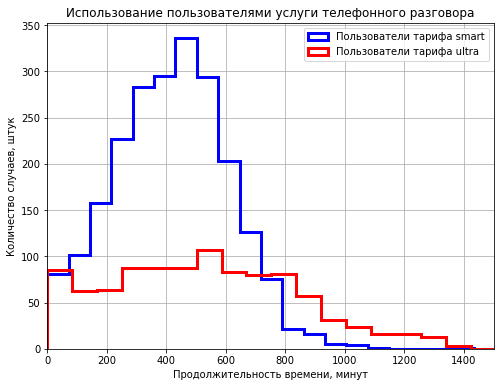

In [45]:
ax = df_smart['duration'].plot(kind='hist',bins=20,histtype = 'step',linewidth=3, color='b',
    legend=True, label='Пользователи тарифа smart')
df_ultra['duration'].plot(kind='hist',bins=20,histtype = 'step',linewidth=3, color='r',
    legend=True,label='Пользователи тарифа ultra', title='Использование пользователями услуги телефонного разговора',xlim=(0,1500),grid=True,ax=ax,
    figsize=(8,6))
plt.xlabel("Продолжительность времени, минут")
plt.ylabel("Количество случаев, штук")   
plt.show()

Продолжительность телефонных разговоров (среднее арифм.) с тарифом 'smart'/'ultra': 417.9/526.6 минут, первый квартиль 282/284, медиана 422/518, третий квартиль 545/752, максимум 1435/1673.

Вывод: 3000 минутами предусмотренными тарифом 'ultra', никто не пользуется, но и 500 минут, предусмотренных тарифом 'smart' хватает не всем.
Стандартное отклонение продолжительности телефонных разговоров 190.3/317.6, что говорит о большом разбросе значений среди пользователей тарифа 'ultra'. Дисперсия составляет 36219/100874.
Среднестатистический (медианный) клиент компании с тарифом 'ultra' разговаривает по телефону на 23% больше (518/422), чем среднестатистический клиент компании с тарифом 'smart'.

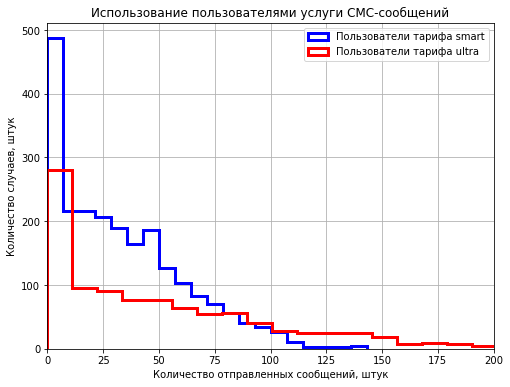

In [46]:
ax = df_smart['count_sms'].plot(kind='hist',bins=20,histtype = 'step',linewidth=3, color='b',
    legend=True, label='Пользователи тарифа smart')
df_ultra['count_sms'].plot(kind='hist',bins=20,histtype = 'step',linewidth=3, color='r',
    legend=True,label='Пользователи тарифа ultra', title='Использование пользователями услуги СМС-сообщений',
    xlim=(0,200),grid=True,ax=ax,figsize=(8,6))

plt.xlabel("Количество отправленных сообщений, штук")
plt.ylabel("Количество случаев, штук")   
plt.show()

Количество отправленных СМС (среднее арифметическое) с тарифом 'smart'/'ultra' 33.38/49.36, медиана 28/38, максимум 143/224. Стандартное отклонение 28.23/47.80, дисперсия составляет 796.8/2285.
Вывод: 1000 сообщений предусмотренными тарифом 'ultra', никто не отправляет, но и 50 сообщений, предусмотренных тарифом 'smart' хватает не всем.
Среднестатистический (медианный) клиент компании с тарифом 'ultra' отправляет текстовых сообщений на 36% больше (38/28), чем среднестатистический клиент компании с тарифом 'smart'.

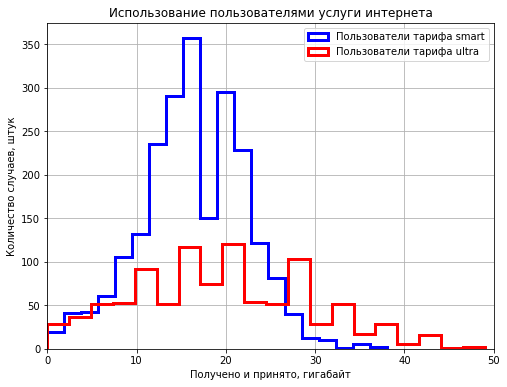

In [47]:
ax = df_smart['gb_used'].plot(kind='hist',bins=20,histtype = 'step',linewidth=3, color='b',
    legend=True, label='Пользователи тарифа smart')
df_ultra['gb_used'].plot(kind='hist',bins=20,histtype = 'step',linewidth=3, color='r',
    legend=True,label='Пользователи тарифа ultra', title='Использование пользователями услуги интернета',xlim=(0,50),grid=True,
        ax=ax,figsize=(8,6))
plt.xlabel("Получено и принято, гигабайт")
plt.ylabel("Количество случаев, штук")   
plt.show()

Интернет-трафик (средний арифметический) с тарифом 'smart'/'ultra' 16,33/19.49 ГБ, медиана 17/19, максимум 38/49. Стандартное отклонение 5.747/9.854, дисперсия составляет 33/97.
Вывод: предусмотренные тарифом 'ultra' лимит информации в 30 ГБ является вполне востребованым, 15 Гб предусмотренных тарифом 'smart' - сравнительно небольшой объем.
Среднестатистический (медианный) клиент компании с тарифом 'ultra' использует интернет на 12% больше (19/17), чем среднестатистический клиент компании с тарифом 'smart'.

Вывод: пользователи тарифа "ultra" больше, чем пользователи тарифа "smart" склонны к большому потреблению количества услуг.

### Исследование настроения клиентов
Автором было обращено внимание не значительное количество пользователей, отказавшихся от тарифа "ultra", в связи с чем стало интересно рассмотреть динамику притока новых клиентов и отказа клиентов от каждого из тарифного плана. Соберем для этого данные: 

,month,plus,minus
0,1,43,NaN
1,2,39,NaN
2,3,32,NaN
3,4,53,NaN
4,5,41,NaN
5,6,40,NaN
6,7,44,NaN
7,8,50,2.0
8,9,35,3.0
9,10,45,9.0


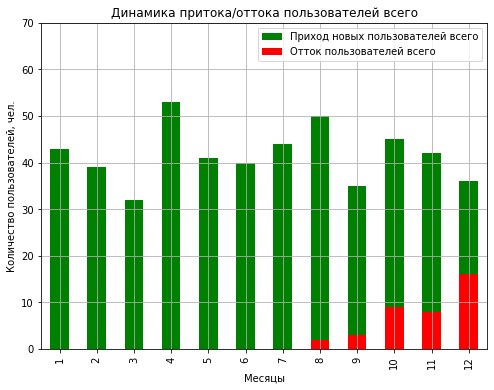

In [48]:
df_users['reg_month'] = pd.DatetimeIndex(df_users['reg_date']).month        # добавляем месяц регистрации пользователя
df_users['chur_month'] = pd.DatetimeIndex(df_users['churn_date']).month     # добавляем месяц отказа пользователя от услуг
#display(df_users.head(10))

# Создаем сводную таблицу с регистрирующимися пользователями
plus = df_users.pivot_table(index=['reg_month'],values='age',aggfunc='count').reset_index()
plus.columns = ['month','plus']
#display(plus)

# Создаем сводную таблицу с удаляющимися пользователями
minus = df_users.pivot_table(index=['chur_month'],values='age',aggfunc='count').reset_index()
minus.columns = ['month','minus']
#display(minus)

dynamics = plus.merge(minus, on='month',how='outer') # объединим таблицы
display(dynamics)

ax = dynamics.plot(x='month',y='plus',ylim=(0,60),kind='bar',legend=True, label='Приход новых пользователей всего',
    grid=True,color='g') # Строим гистограмму
dynamics.plot(x='month',y='minus',ylim=(0,70),kind='bar',legend=True, label='Отток пользователей всего',
    xlim=(0,5), color='r', grid=True,figsize=(8,6),ax=ax, title='Динамика притока/оттока пользователей всего') # Строим гистограмму
plt.xlabel("Месяцы")
plt.ylabel("Количество пользователей, чел.")   
plt.show()


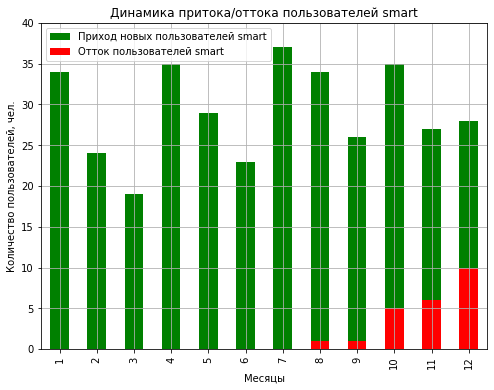

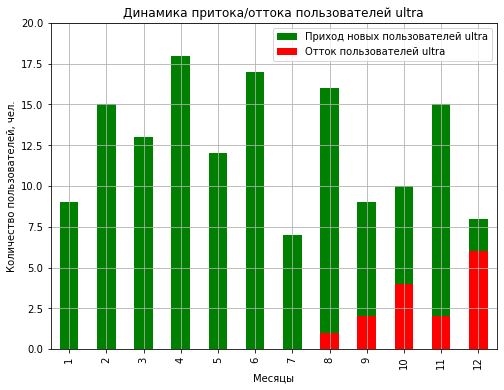

In [49]:
df_users_ultra = df_users[df_users['tariff']=='ultra']        # фильтруем по тарифу
df_users_smart = df_users[df_users['tariff']=='smart']        # фильтруем по тарифу
#display(df_users_ultra.head())
#display(df_users_smart.head())

# Создаем сводную таблицу с регистрирующимися пользователями по смарту
plus_smart = df_users_smart.pivot_table(index=['reg_month'],values='age',aggfunc='count').reset_index()
plus_smart.columns = ['month','plus']
#display(plus_smart)
# Создаем сводную таблицу с регистрирующимися пользователями по ультре
plus_ultra = df_users_ultra.pivot_table(index=['reg_month'],values='age',aggfunc='count').reset_index()
plus_ultra.columns = ['month','plus']
#display(plus_ultra)

# Создаем сводную таблицу с удаляющимися пользователями по смарту
minus_smart = df_users_smart.pivot_table(index=['chur_month'],values='age',aggfunc='count').reset_index()
minus_smart.columns = ['month','minus']
#display(minus_smart)
# Создаем сводную таблицу с удаляющимися пользователями по ультре
minus_ultra = df_users_ultra.pivot_table(index=['chur_month'],values='age',aggfunc='count').reset_index()
minus_ultra.columns = ['month','minus']
#display(minus_ultra)

dynamics_smart = plus_smart.merge(minus_smart, on='month',how='outer') # объединим таблицы по смарту
#display(dynamics)
dynamics_ultra = plus_ultra.merge(minus_ultra, on='month',how='outer') # объединим таблицы по ультре
#display(dynamics)

ax = dynamics_smart.plot(x='month',y='plus',kind='bar',legend=True, label='Приход новых пользователей smart',
    grid=True,color='g') # Строим гистограмму
dynamics_smart.plot(x='month',y='minus',ylim=(0,40),kind='bar',legend=True, label='Отток пользователей smart',
    xlim=(0,5), color='r', grid=True,figsize=(8,6),ax=ax, title='Динамика притока/оттока пользователей smart') # Строим гистограмму
plt.xlabel("Месяцы")
plt.ylabel("Количество пользователей, чел.")   
plt.show()

ax = dynamics_ultra.plot(x='month',y='plus',kind='bar',legend=True, label='Приход новых пользователей ultra',
    grid=True,color='g') # Строим гистограмму
dynamics_ultra.plot(x='month',y='minus',ylim=(0,20),kind='bar',legend=True, label='Отток пользователей ultra',
    xlim=(0,5), color='r', grid=True,figsize=(8,6),ax=ax, title='Динамика притока/оттока пользователей ultra') # Строим гистограмму
plt.xlabel("Месяцы")
plt.ylabel("Количество пользователей, чел.")   
plt.show()

Хотя по обоим тарифным планам ежемесячный приток новых пользователей в течение года сохранялся на весьма значительном уровне, однако с августа возникла проблема значительного оттока клиентов (отказа от телекоммуникационных услуг) в количестве до 16 человек (всего), что составляет до 45% от количества новых пользователей. **По имеющимся данным, процент отказывающихся от услуг пользователей стремительно нарастает.**

Среди пользователей наибольший отток (кроме ноября) наблюдается среди пользователей тарифного плана 'ultra' (в процентном отношении от количества новых пользователей).

Это факты свидетельствует о неудовлетворенности и незаинтересованности клиентов; возможно, и к постепенному уходу в другую телекоммуникационную компанию.

В долгосрочной перспективе это может привести к недополучению ожидаемой выручки, повышению риска кризиса компании с сокращением менеджеров и аналитиков, пропустивших такую динамику :)

### Проверка гипотезы о равенстве выручки пользователей двух тарифных планов

Сформулируем нулевую гипотезу H₀: **"Средняя выручка от пользователей тарифа "Ультра" равна средней выручке от пользователей тарифа "Смарт"".**

Сформулируем альтернативную гипотезу H₁ (утверждение, которое принимается верным, если отбрасывается H₀): **"Средняя выручка от пользователей тарифа "Ультра" не равна выручке пользователей тарифа "Смарт"".** 

Воспользуемся методом scipy.stats.ttest_ind() c атрибутом qual=False в связи с разной дисперсией и разного размера выборок (хотя выборки большие, заморачиваться было не обязательно), и создадим соответствующую функцию, которая упростит проверку гипотез.

Критический уровень статистической значимости примем равный 0,05 (рекомендуемый документацией для данного метода).

   Длина первого датафрейма 2230
   Длина второго датафрейма 986

   Дисперсия данных в первом датафрейме  669430
   Дисперсия данных во втором датафрейме 141244

   p - значение: 1.927011394420941e-250 ( 0.0 )
   Отвергаем нулевую гипотезу о равенстве выручки от пользователей разных тарифов


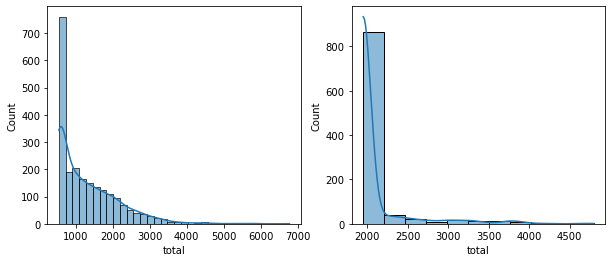

In [53]:
def hypothesis(text,alpha, df_1,df_2):     
    print('   Длина первого датафрейма', len(df_1))
    print('   Длина второго датафрейма', len(df_2))
    print()
    print('   Дисперсия данных в первом датафрейме ', round(np.var(df_1)))
    print('   Дисперсия данных во втором датафрейме', round(np.var(df_2)))
    print() 
    result = st.ttest_ind(df_1, df_2,equal_var = False)                  # активируем метод 
    print('   p - значение:',result.pvalue,'(',round(result.pvalue,4),')')                               # выводим на экран 
    if result.pvalue < alpha:
        print('   Отвергаем нулевую гипотезу',text)
    else:
        print('   Нет причин отвергать нулевую гипотезу',text)
    
    fig, ax = plt.subplots(nrows = 1, ncols=2, figsize=(10, 4))
    #вытягиваем
    ax = ax.flatten()
    sns.histplot(data = df_1, ax=ax[0], kde = True,palette='muted')
    sns.histplot(data = df_2, ax=ax[1], kde = True,palette='muted')
    plt.show() 
    
hypothesis('о равенстве выручки от пользователей разных тарифов',0.05, df_smart['total'],
    df_ultra['total'])

Промежуточный вывод:  нулевая гипотеза отвергнута (слишком малое значение p, то есть cредняя выручка от пользователей тарифа ultra значительно отличается от выручки пользователей тарифа smart).

### Проверка гипотезы о равенстве выручки москвичей и жителей других регионов.

Сформулируем нулевую гипотезу H₀: **"Средняя выручка от пользователей из Москвы равна выручке пользователей из других регионов.**

Сформулируем альтернативную гипотезу H₁ (утверждение, которое принимается верным, если отбрасывается H₀): **"Средняя выручка от пользователей из Москвы не равна средней выручке от пользователей из других регионов".**

Для проверки данной гипотезы сначала создадим соответствующие выборки данных:

In [54]:
df_users_all = df_users_all.merge(df_users['city'], on='user_id',how='outer') # добавим название города
display(df_users_all.head())

df_msk = df_users_all[df_users_all['city']=='Москва']
df_other = df_users_all[df_users_all['city']!='Москва']
display(df_msk.head())
df_other.head()

,user_id,month,duration,count,count_sms,mb_used,gb_used,tariff,total,city
0,1000,5.0,159.0,22.0,22.0,2253.49,3.0,ultra,1950.0,Краснодар
1,1000,6.0,172.0,43.0,60.0,23233.77,23.0,ultra,1950.0,Краснодар
2,1000,7.0,340.0,47.0,75.0,14003.64,14.0,ultra,1950.0,Краснодар
3,1000,8.0,408.0,52.0,81.0,14055.93,14.0,ultra,1950.0,Краснодар
4,1000,9.0,466.0,58.0,57.0,14568.91,15.0,ultra,1950.0,Краснодар


,user_id,month,duration,count,count_sms,mb_used,gb_used,tariff,total,city
8,1001,11.0,430.0,59.0,0.0,18429.34,18.0,smart,1150.0,Москва
9,1001,12.0,414.0,63.0,0.0,14036.66,14.0,smart,550.0,Москва
17,1003,8.0,380.0,55.0,37.0,8565.21,9.0,ultra,1950.0,Москва
18,1003,9.0,961.0,134.0,91.0,12468.87,13.0,ultra,1950.0,Москва
19,1003,10.0,855.0,108.0,83.0,14768.14,15.0,ultra,1950.0,Москва


,user_id,month,duration,count,count_sms,mb_used,gb_used,tariff,total,city
0,1000,5.0,159.0,22.0,22.0,2253.49,3.0,ultra,1950.0,Краснодар
1,1000,6.0,172.0,43.0,60.0,23233.77,23.0,ultra,1950.0,Краснодар
2,1000,7.0,340.0,47.0,75.0,14003.64,14.0,ultra,1950.0,Краснодар
3,1000,8.0,408.0,52.0,81.0,14055.93,14.0,ultra,1950.0,Краснодар
4,1000,9.0,466.0,58.0,57.0,14568.91,15.0,ultra,1950.0,Краснодар


Воспользуемся созданной функцией, критический уровень статистической значимости примем равный 0,05 (рекомендуемый документацией для данного метода):

   Длина первого датафрейма 611
   Длина второго датафрейма 2605

   Дисперсия данных в первом датафрейме  564711
   Дисперсия данных во втором датафрейме 653818

   p - значение: 0.5216952110000279 ( 0.5217 )
   Нет причин отвергать нулевую гипотезу о равенстве выручки москвичей и жителей других регионов


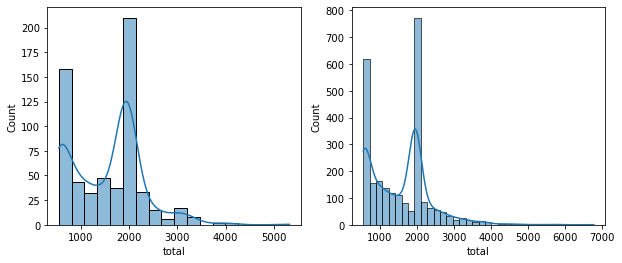

In [55]:
hypothesis('о равенстве выручки москвичей и жителей других регионов',0.05, 
    df_msk['total'], df_other['total'])

## Общий вывод

В результате исследования установлено:

**1.Поведение клиентов тарифных планов 'smart'/'ultra':**
- Средняя месячная выручка составляет 1289/2070 рублей (в пользу 'ultra'), общее количество использования тарифа составляет 351/149 чел, общая сумма выручки за год составляет 2876/2041 тыс. руб, поэтому телекомуникационная компания больше выручки получает от тарифа 'smart';
- Продолжительность телефонных разговоров 417,9/526,6 минут, медиана 422/518, максимум 1435/1673;
- 3000 минутами предусмотренными тарифом 'ultra', никто не пользуется, но и 500 минут, предусмотренных тарифом 'smart' хватает не всем; 
- Среднестатистический (медианный) клиент компании с тарифом 'ultra' разговаривает по телефону на 23% больше, чем среднестатистический клиент компании с тарифом 'smart';
- Количество отправленных СМС среднее арифметическое 33,38/49,36, медиана 28/38, максимум 143/224; 
- Вывод: 1000 сообщений предусмотренными тарифом 'ultra', никто не отправляет, но и 50 сообщений, предусмотренных тарифом 'smart' хватает не всем; 
- Среднестатистический (медианный) клиент компании с тарифом 'ultra' отправляет текстовых сообщений на 36% больше, чем среднестатистический клиент компании с тарифом 'smart';
- Интернет-трафик средний 16,33/19,49 ГБ, медиана 17/19, максимум 38/49; 
- Вывод: предусмотренны тарифом 'ultra' лимит информации в 30 ГБ является вполне востребованым, 15 Гб предусмотренных тарифом 'smart' - сравнительно небольшой объем; 
- Среднестатистический (медианный) клиент компании с тарифом 'ultra' использует интернет на 12% больше, чем среднестатистический клиент компании с тарифом 'smart';
- Псевдоэкономный тарифный план 'smart' на самом деле приносит большую выручку, сопоставимую с выручкой от 'ultra', за счет большего количества пользователей тарифа 'smart'.

**2. По данным построения гистограмм:**
- Пользователи тарифа 'ultra' больше, чем пользователи тарифа 'smart' склонны к большому потреблению количества услуг.

**3. Дополнительное исследование динамики количества клиентов:**
- Наблюдается увеличение количества клиентов, отказывающихся от телекоммуникационных услуг, причем их количество ежемесячно возрастает. Так, в декабре доля клиентов, отказавшихся от услуг составляла уже 44% от количества новых клиентов;
- Этот факт свидетельствует о неудовлетворенности телекоммуникационной компанией и незаинтересованности в ее услугах клиентов, и возможно, и к постепенному уходу в другую телекоммуникационную компанию;
- В долгосрочной перспективе это может привести к недополучению ожидаемой выручки и повышению риска кризиса компании.

**4. Проверка гипотезы о различии выручки пользователей двух тарифных планов:**
- нулевая гипотеза отвергнута (слишком малое значение p, то есть cредняя выручка от пользователей тарифа ultra значительно отличается от выручки пользователей тарифа smart).

**5. Проверка гипотезы о различии выручки москвичей и жителей других регионов:**
- не получилось отвергнуть нулевую гипотезу (очень большое значение p, то есть cредняя выручка от пользователей из Москвы похожа на среднюю выручку от пользователей из других городов.

**6. Итоговое резюме:**
- У телекоммуникационной компании большая выручка от каждого пользователя, использующего тариф 'ultra', но большинство клиентов (вероятно, из-за низкой абоненсткой платы) используют тариф 'smart', поэтому телекоммуникационная компания суммарно получает больше выручки от пользователей тарифа 'smart';
- Среди аудитории клиентов телекоммуникационной компании целесообразнее проводить рекламную компанию, направленную на переход клиентов на пользование тарифа 'ultra' (дает больше выручки компании);
- Рекламную компанию по привлечению новых клиентов (среди аудитории, не являющихся клиентами телекоммуникационной компании), целесообразнее проводить по "выгодному" для клиентов (на первый взгляд) тарифу 'smart';
- Однако, эти рекламыне компании могут оказаться неэффективными в связи с нарастающим недовольством среди клиентов и их увеличивающемся отказе от услуг телекоммуникационной компании. Следует срочно принять исчерпывающие меры для снижения оттока клиентов компании.